In [3]:
import pandas as pd

df = pd.read_csv('csgo_round_snapshots.csv')
df = df.drop(columns=['time_left'])

df.head()

,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('round_winner', axis=1)
y = df['round_winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

from sklearn.metrics import accuracy_score

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.89


In [5]:
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_

ohe_columns = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_cols)

all_columns = numerical_cols.to_list() + ohe_columns.tolist()

sorted_importances = sorted(zip(feature_importances, all_columns), reverse=True)

for feature in sorted_importances:
    print(f"{feature[1]}: {feature[0]}")

t_armor: 0.07792708873623964
ct_armor: 0.07448305748380847
t_money: 0.05816446141789404
ct_money: 0.055615249825545804
t_helmets: 0.044120744828472475
t_score: 0.034225230946839665
ct_score: 0.03371086274970448
t_health: 0.033294643135306
ct_health: 0.03297414438553162
ct_defuse_kits: 0.03009553059308894
t_weapon_ak47: 0.027544133999794513
ct_helmets: 0.026432908911991983
ct_grenade_flashbang: 0.025526814375303762
t_grenade_flashbang: 0.0234035661833187
t_players_alive: 0.021053044048052087
t_weapon_glock: 0.020680282173165688
ct_grenade_smokegrenade: 0.019772868865734167
ct_weapon_usps: 0.019742607818198726
ct_weapon_m4a4: 0.018747178306453286
ct_players_alive: 0.01735463681619242
ct_grenade_incendiarygrenade: 0.01664369426557548
t_weapon_sg553: 0.016626848990275177
t_grenade_smokegrenade: 0.016456549071276538
ct_grenade_hegrenade: 0.01572665930636922
ct_weapon_awp: 0.015602942520485724
t_grenade_molotovgrenade: 0.015333431334590232
t_grenade_hegrenade: 0.010584081858666407
ct_weapon_

In [6]:
non_zero_importance_feature_names = [name for importance, name in sorted_importances if importance > 0]

important_features = [col for col in numerical_cols if col in non_zero_importance_feature_names] + \
                     [col for col in categorical_cols if col in non_zero_importance_feature_names]

preprocessor_adjusted = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [col for col in numerical_cols if col in important_features]),
        ('cat', categorical_transformer, [col for col in categorical_cols if col in important_features])
    ])

rf_pipeline_adjusted = Pipeline(steps=[
    ('preprocessor', preprocessor_adjusted),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

X_train_adjusted = X_train[important_features]
X_test_adjusted = X_test[important_features]
rf_pipeline_adjusted.fit(X_train_adjusted, y_train)

y_pred_adjusted = rf_pipeline_adjusted.predict(X_test_adjusted)
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)

print(f"Adjusted Model Accuracy: {accuracy_adjusted:.2f}")

Adjusted Model Accuracy: 0.88


In [7]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(
    rf_pipeline_adjusted,
    X_train_adjusted,
    y_train,
    cv=10,
    scoring='accuracy')

cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print(f"Mean CV Accuracy: {cv_scores_mean:.2f}")
print(f"CV Accuracy Standard Deviation: {cv_scores_std:.2f}")

Mean CV Accuracy: 0.87
CV Accuracy Standard Deviation: 0.00


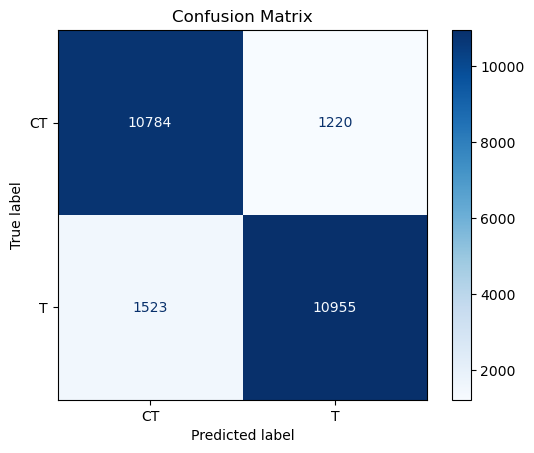

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipeline.classes_)

import matplotlib.pyplot as plt

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Adjusted AUC: 0.95


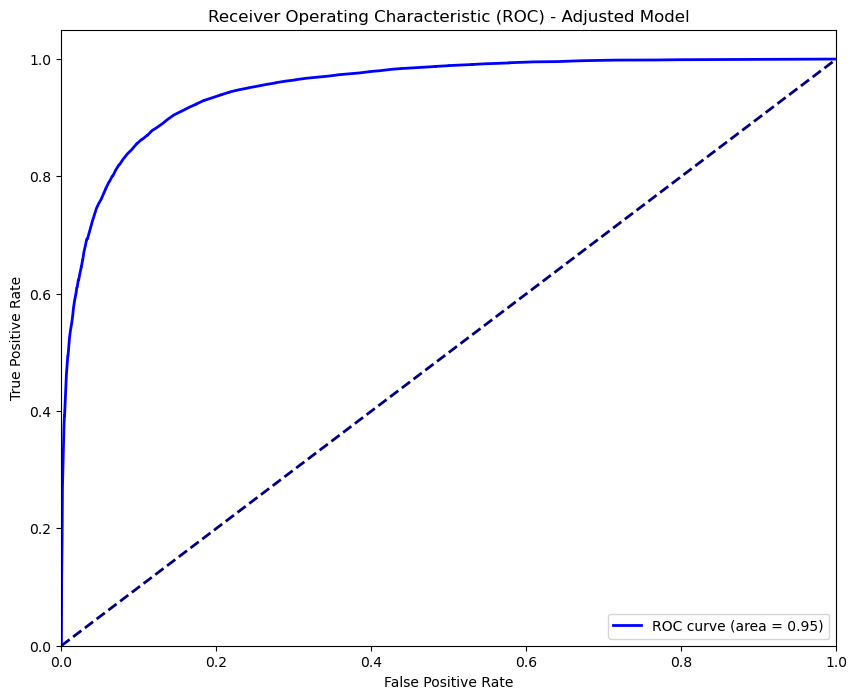

In [9]:
y_pred_prob_adjusted = rf_pipeline_adjusted.predict_proba(X_test_adjusted)

from sklearn.metrics import roc_curve, auc

positive_class_prob_adjusted = y_pred_prob_adjusted[:, 1]

fpr_adjusted, tpr_adjusted, _ = roc_curve(y_test, positive_class_prob_adjusted, pos_label='T')
roc_auc_adjusted = auc(fpr_adjusted, tpr_adjusted)

print(f"Adjusted AUC: {roc_auc_adjusted:.2f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr_adjusted, tpr_adjusted, color='blue',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_adjusted)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Adjusted Model')
plt.legend(loc="lower right")
plt.show()

The AUC-PR score is: 0.30


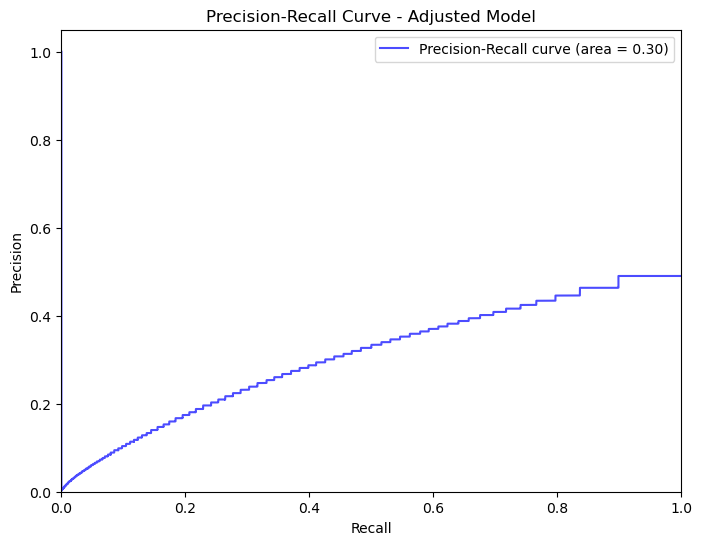

In [10]:
positive_class_probabilities = y_pred_prob_adjusted[:, 1]

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, positive_class_probabilities, pos_label='CT')

average_precision = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.7,
         label='Precision-Recall curve (area = %0.2f)' % average_precision)

print(f"The AUC-PR score is: {average_precision:.2f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve - Adjusted Model')
plt.legend(loc='upper right')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, classification_report

df_new = pd.read_csv("result.csv") # result_mirage.csv
X_new = df_new.drop(columns=['round_winner', 'round_number'])

df = df.loc[:, ~df.columns.duplicated()]

df_new.columns = df_new.columns.str.strip()

predictions = rf_pipeline_adjusted.predict(X_new)

df_new['predicted_winner'] = predictions
accuracy = accuracy_score(df_new['round_winner'], df_new['predicted_winner'])
print(f"Prediction Accuracy: {accuracy:.2f}")

print(classification_report(df_new['round_winner'], df_new['predicted_winner']))

Prediction Accuracy: 0.91
              precision    recall  f1-score   support

          CT       1.00      0.82      0.90        11
           T       0.85      1.00      0.92        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22



In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("result_mirage.csv", skip_blank_lines=False) # result.csv for mirage

df.columns = df.columns.str.strip()

X = df.drop(columns=['round_winner'])
y = df['round_winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

rf_pipeline_adjusted = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline_adjusted.fit(X_train, y_train)

test_case_1 = df.iloc[12]
test_case_2 = df.iloc[26]
# test_case_3 = df.iloc[0]  # inferno
# test_case_4 = df.iloc[13] # inferno

test_cases_df = pd.DataFrame([test_case_1, test_case_2])
X_test_cases = test_cases_df.drop(columns=['round_winner'])

predictions = rf_pipeline_adjusted.predict(X_test_cases)

test_cases_df['predicted_winner'] = predictions

print(test_cases_df[['map', 'bomb_planted', 'ct_players_alive', 't_players_alive', 'round_winner', 'predicted_winner']])

          map  bomb_planted  ct_players_alive  t_players_alive round_winner  \
12  de_mirage         False                 1                4            T   
26  de_mirage          True                 4                2           CT   

   predicted_winner  
12                T  
26               CT  
